Running at: hbp-image-service.desy.de for protocol: http
('Go binaries at: %s', '/usr/local/go/bin/go\n')
<open file '<fdopen>', mode 'rb' at 0x10fdc0ed0>


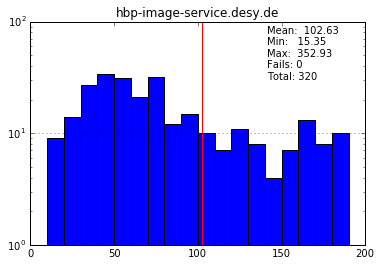

Running at: fsd-cloud47.zam.kfa-juelich.de for protocol: https
('Go binaries at: %s', '/usr/local/go/bin/go\n')
<open file '<fdopen>', mode 'rb' at 0x10fdc0ed0>


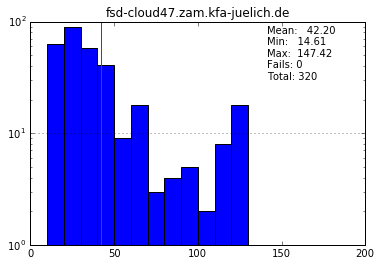

Running at: fsd-cloud47.zam.kfa-juelich.de for protocol: http
('Go binaries at: %s', '/usr/local/go/bin/go\n')
<open file '<fdopen>', mode 'rb' at 0x10fdc0ed0>


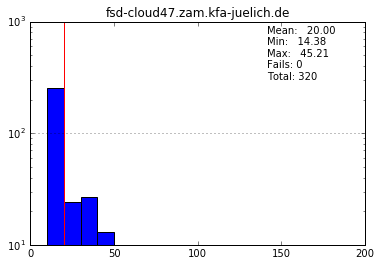

In [113]:
##
## For this script to work in httpRequest.go the logging level needs to be set to debug
##

import numpy
import time
import matplotlib.pyplot as plt
import subprocess
from math import ceil
import select

def toMs(s):
    """
    The test script returns timings in the format
    nnn,nn[m]s
    We need to decode the input line, replace commas with dots, and
    normalize to ms.
    """
    s2 = s.decode("UTF-8").replace(",", ".").strip()
    if s2[-2:] == "ms":
        return float(s2[:-2])
    elif s2[-1:] == "s":
        return 1000 * float(s2[:-1])
    else:
        return float(s2)
    
fails = 0
total = 0
        
def nonZeroLine(l):
    global fails, total
    for line in l:
        total = total + 1
        if line != "0":
            yield line
        else:
            fails = fails + 1

def pipe_is_empty(pipe):
    if select.select([pipe,],[],[],0.0)[0]:
        # Pipe has data
        return False
    else:
        # Pipe has no data
        return True
            
def runTest(site, protocol):
    global fails, total
    fails = 0
    total = 0
    

    goBinary = subprocess.Popen("which go", shell=True, stdout=subprocess.PIPE).stdout.read()    
    print ("Go binaries at: %s", goBinary)    
    
    cmd = "%s run httpRequest.go MetaData.go %s %s 2>&1 | awk '/Result for bunch/ { print $9 }' | sed -e 's/\"//'" % (goBinary.replace("\n", ""), protocol, site)
    
    sp = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE).stdout    
    print(sp)
    if pipe_is_empty(sp) :
        data = numpy.loadtxt(nonZeroLine(sp), converters={ 0: toMs })

        %matplotlib inline
        max = 200 #int(ceil(data.max()))
        min = int(data.min())
        plt.hist(data, range(0, max, int(max / 20)))
        plt.yscale('log')
        plt.annotate("Mean: %7.2f\nMin: %7.2f\nMax: %7.2f\nFails: %d\nTotal: %d" % (data.mean(), data.min(), data.max(), fails, total), (0.7, 0.7), xycoords="figure fraction")
        plt.title(site)
        plt.axvline(data.mean(), color='red')
        plt.grid(axis='y')
        plt.show()
    else:
        print("Stdout for command: \n\n %s \n\n did not return anything.\n" % (cmd))
        print("GoLocation empty? %s" % (goBinary))
        
sites = [
          "http://hbp-image-service.desy.de",
#          "http://131.169.4.31:8888",
#          "http://149.156.9.143:8888",
          "https://fsd-cloud47.zam.kfa-juelich.de",
           "http://fsd-cloud47.zam.kfa-juelich.de"
#        "http://localhost:8000"
]

for site in sites:
    protocol = site.split(":")[0]
    siteName = site.split(":")[1].replace("/", "")
    print("Running at: %s for protocol: %s" % (siteName, protocol))
    runTest(siteName, protocol)